# Paths

In [ ]:
dataset_path = "../datasets/SimpleSoyBean"
tensorboard_path = "../logs/"
models_path = "../models/SoyBean/"

# Dataloader

In [3]:
import matplotlib.pyplot as plt
import numpy as np

def my_tensor_image_show ( image , label=None ):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image)
    plt.axis('off')
    if label is None :
        plt.title('Image in tensor format.')
    else :
        plt.title(f'Image in tensor format | Class: {label:2d}')
    plt.show()    

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# função para dividir o dataset em treino e teste
def train_test_dataset(dataset, test_split=0.25):
    train_idx, test_idx = train_test_split(list(range(len(dataset))), test_size=test_split)
    train_data = Subset(dataset, train_idx)
    test_data = Subset(dataset, test_idx)
    return train_data, test_data

In [ ]:
# transformações para a ResNet18
from torchvision.models import ResNet18_Weights
my_transform = ResNet18_Weights.IMAGENET1K_V1.transforms()

In [ ]:
import torch
import torchvision

# carrega o dataset de imagens com as transformações definidas
data = torchvision.datasets.ImageFolder(root=dataset_path, transform=my_transform)

# divide o dataset em treino e teste
train_data, test_data = train_test_dataset(data, 0.30)

batch_size = 512

train_tensors = torch.utils.data.DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_tensors = torch.utils.data.DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)
print(len(data))
print(len(train_data))
print(len(test_data))

In [ ]:
images, labels = next(iter(train_tensors))
my_tensor_image_show(images[0], label=labels[0])

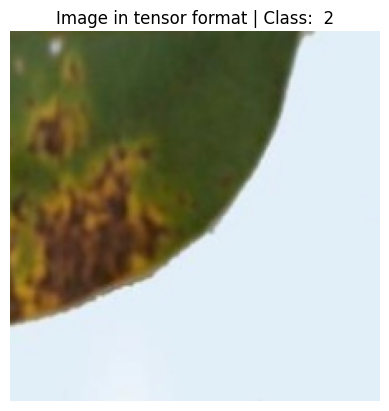

In [ ]:
images, labels = next(iter(test_tensors))
my_tensor_image_show(images[0], label=labels[0])

# Training

In [ ]:
from torch.utils.tensorboard import SummaryWriter

import torch.optim 
import matplotlib.pyplot as plt
  
from datetime import datetime

from tqdm import tqdm

import copy

def plot_layers ( net , writer, epoch ) :
    layers = list(net.fc.modules())
    
    layer_id = 1
    for layer in layers:
        if isinstance(layer, torch.nn.Linear) :

#             writer.add_histogram('Bias/conv{}'.format(layer_id), layer.bias, 
#                                 epoch )
            writer.add_histogram('Weight/conv{}'.format(layer_id), layer.weight, 
                                epoch )
#             writer.add_histogram('Grad/conv{}'.format(layer_id), layer.weight.grad, 
#                                     epoch )
            layer_id += 1


def train ( train_loader, test_loader, net, dataset_size, my_device='cpu',
           prefix=None, upper_bound=100.0, save=False, epochs=100, 
           lr=1e-1, device='cpu', debug=False, layers2tensorboard=False , batch_size=64) :

    # otimizador e função de perda
    optimizer = torch.optim.Adam(net.parameters(),lr=lr)
    criterion = torch.nn.CrossEntropyLoss()
    
    now = datetime.now()
    suffix = now.strftime("%Y%m%d_%H%M%S")
    prefix = suffix if prefix is None else prefix + '-' + suffix  

    writer = SummaryWriter( log_dir=tensorboard_path+prefix )
        
    accuracies = []
    max_accuracy = -1.0  

    for inputs, labels in train_loader:
        print("Labels:", labels.unique())
        break


    for epoch in tqdm(range(epochs), desc='Training epochs...') :
        net.train()
        for idx, (train_x, train_label) in enumerate(train_loader):
            train_x = train_x.to(device)
            train_label = train_label.to(device)

            predict_y = net( train_x )
            
            # loss
            error = criterion( predict_y , train_label )

            writer.add_scalar( 'Loss/train', error.cpu().item(), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            # backpropagation
            optimizer.zero_grad()
            error.backward()
            optimizer.step()
            
            # accuracy
            predict_ys = torch.max( predict_y, axis=1 )[1]
            correct    = torch.sum(predict_ys == train_label)

            writer.add_scalar( 'Accuracy/train', correct/train_x.size(0), 
                                idx+( epoch*(dataset_size//batch_size) ) )

            if debug and idx % 10 == 0 :
                print( f'idx: {idx:4d}, _error: {error.cpu().item():5.2f}' )

        if layers2tensorboard :
            plot_layers( net, writer, epoch )

        accuracy = validate(net, test_loader, device=device)
        accuracies.append(accuracy)
        writer.add_scalar( 'Accuracy/test', accuracy, epoch )
        
        if accuracy > max_accuracy :
            best_model = copy.deepcopy(net)
            max_accuracy = accuracy
            print("Saving Best Model with Accuracy: ", accuracy)
        
        print( f'Epoch: {epoch+1:3d} | Accuracy : {accuracy:7.4f}%' )

        if accuracy > upper_bound :
            break
    
    if save : 
        dataset = "SoyBean"
        path = f'{models_path}ResNet18-{dataset}-{max_accuracy:.2f}.pkl'
        torch.save(best_model, path)
        print('Model saved in:',path)
    
    plt.plot(accuracies)

    writer.flush()
    writer.close()
    
    return best_model    

# Validation

In [ ]:
# função de validação do modelo
def validate ( model , data , device='cpu') :

    model.eval()

    correct = 0
    sum = 0
    
    for idx, (test_x, test_label) in enumerate(data) : 
        test_x = test_x.to(device)
        test_label = test_label.to(device)
        predict_y = model( test_x ).detach()
        predict_ys = torch.max( predict_y, axis=1 )[1]
        sum = sum + test_x.size(0)
        correct = correct + torch.sum(predict_ys == test_label)
        correct = correct.cpu().item()
    
    return correct*100./sum

# Run

In [11]:
import torch
from torchvision.models import resnet18

# arquivo com modelo treinado no dataset SoyNet
path = './models/SoyNet/ResNet18-SoyNet-96.07.pkl'

# carrega o modelo
modelResNetTL = torch.load(path, weights_only=False)

# verifica as camadas
for name, param in modelResNetTL.named_parameters():
    print(f"{name}")


conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.we

In [ ]:
# congela as camadas do modelo
for param in modelResNetTL.parameters():
    param.requires_grad = False

# habilita o treinamento da camada final - Transfer Learning
modelResNetTL.fc.requires_grad_(True)

# define o número de classes do dataset SoyBean
num_classes = 13
modelResNetTL.fc = torch.nn.Linear(modelResNetTL.fc.in_features, num_classes)

In [ ]:
# verifica as camadas que estão congeladas
for name, param in modelResNetTL.named_parameters():
    status = "Trainable" if param.requires_grad else "Frozen"
    print(f"{name}: {status}")

conv1.weight: Frozen
bn1.weight: Frozen
bn1.bias: Frozen
layer1.0.conv1.weight: Frozen
layer1.0.bn1.weight: Frozen
layer1.0.bn1.bias: Frozen
layer1.0.conv2.weight: Frozen
layer1.0.bn2.weight: Frozen
layer1.0.bn2.bias: Frozen
layer1.1.conv1.weight: Frozen
layer1.1.bn1.weight: Frozen
layer1.1.bn1.bias: Frozen
layer1.1.conv2.weight: Frozen
layer1.1.bn2.weight: Frozen
layer1.1.bn2.bias: Frozen
layer2.0.conv1.weight: Frozen
layer2.0.bn1.weight: Frozen
layer2.0.bn1.bias: Frozen
layer2.0.conv2.weight: Frozen
layer2.0.bn2.weight: Frozen
layer2.0.bn2.bias: Frozen
layer2.0.downsample.0.weight: Frozen
layer2.0.downsample.1.weight: Frozen
layer2.0.downsample.1.bias: Frozen
layer2.1.conv1.weight: Frozen
layer2.1.bn1.weight: Frozen
layer2.1.bn1.bias: Frozen
layer2.1.conv2.weight: Frozen
layer2.1.bn2.weight: Frozen
layer2.1.bn2.bias: Frozen
layer3.0.conv1.weight: Frozen
layer3.0.bn1.weight: Frozen
layer3.0.bn1.bias: Frozen
layer3.0.conv2.weight: Frozen
layer3.0.bn2.weight: Frozen
layer3.0.bn2.bias: F

Running on cuda
Labels: tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12])


Training epochs...:   1%|          | 1/100 [05:29<9:03:48, 329.58s/it]

Saving Best Model with Accuracy:  9.116809116809117
Epoch:   1 | Accuracy :  9.1168%


Training epochs...:   2%|▏         | 2/100 [06:56<5:05:16, 186.90s/it]

Epoch:   2 | Accuracy :  8.8319%


Training epochs...:   3%|▎         | 3/100 [08:23<3:48:41, 141.45s/it]

Saving Best Model with Accuracy:  9.401709401709402
Epoch:   3 | Accuracy :  9.4017%


Training epochs...:   4%|▍         | 4/100 [09:53<3:13:15, 120.78s/it]

Saving Best Model with Accuracy:  10.256410256410257
Epoch:   4 | Accuracy : 10.2564%


Training epochs...:   5%|▌         | 5/100 [11:22<2:53:15, 109.42s/it]

Epoch:   5 | Accuracy :  9.9715%


Training epochs...:   6%|▌         | 6/100 [12:53<2:41:39, 103.19s/it]

Saving Best Model with Accuracy:  10.54131054131054
Epoch:   6 | Accuracy : 10.5413%


Training epochs...:   7%|▋         | 7/100 [14:23<2:33:30, 99.03s/it] 

Epoch:   7 | Accuracy :  9.6866%


Training epochs...:   8%|▊         | 8/100 [15:55<2:28:06, 96.59s/it]

Saving Best Model with Accuracy:  11.11111111111111
Epoch:   8 | Accuracy : 11.1111%


Training epochs...:   9%|▉         | 9/100 [17:25<2:23:22, 94.53s/it]

Epoch:   9 | Accuracy : 11.1111%


Training epochs...:  10%|█         | 10/100 [18:55<2:19:36, 93.07s/it]

Saving Best Model with Accuracy:  11.965811965811966
Epoch:  10 | Accuracy : 11.9658%


Training epochs...:  11%|█         | 11/100 [20:24<2:16:37, 92.10s/it]

Saving Best Model with Accuracy:  12.535612535612536
Epoch:  11 | Accuracy : 12.5356%


Training epochs...:  12%|█▏        | 12/100 [21:54<2:13:44, 91.19s/it]

Saving Best Model with Accuracy:  13.39031339031339
Epoch:  12 | Accuracy : 13.3903%


Training epochs...:  13%|█▎        | 13/100 [23:23<2:11:39, 90.80s/it]

Saving Best Model with Accuracy:  14.52991452991453
Epoch:  13 | Accuracy : 14.5299%


Training epochs...:  14%|█▍        | 14/100 [24:53<2:09:46, 90.54s/it]

Epoch:  14 | Accuracy : 14.5299%


Training epochs...:  15%|█▌        | 15/100 [26:24<2:08:22, 90.61s/it]

Saving Best Model with Accuracy:  14.814814814814815
Epoch:  15 | Accuracy : 14.8148%


Training epochs...:  16%|█▌        | 16/100 [27:54<2:06:33, 90.40s/it]

Saving Best Model with Accuracy:  15.66951566951567
Epoch:  16 | Accuracy : 15.6695%


Training epochs...:  17%|█▋        | 17/100 [29:23<2:04:17, 89.84s/it]

Saving Best Model with Accuracy:  17.37891737891738
Epoch:  17 | Accuracy : 17.3789%


Training epochs...:  18%|█▊        | 18/100 [30:52<2:02:27, 89.60s/it]

Saving Best Model with Accuracy:  19.943019943019944
Epoch:  18 | Accuracy : 19.9430%


Training epochs...:  19%|█▉        | 19/100 [32:21<2:00:48, 89.49s/it]

Saving Best Model with Accuracy:  22.22222222222222
Epoch:  19 | Accuracy : 22.2222%


Training epochs...:  20%|██        | 20/100 [33:51<1:59:33, 89.67s/it]

Saving Best Model with Accuracy:  23.36182336182336
Epoch:  20 | Accuracy : 23.3618%


Training epochs...:  21%|██        | 21/100 [35:22<1:58:28, 89.98s/it]

Saving Best Model with Accuracy:  25.641025641025642
Epoch:  21 | Accuracy : 25.6410%


Training epochs...:  22%|██▏       | 22/100 [36:52<1:56:54, 89.93s/it]

Saving Best Model with Accuracy:  26.210826210826212
Epoch:  22 | Accuracy : 26.2108%


Training epochs...:  23%|██▎       | 23/100 [38:20<1:54:58, 89.59s/it]

Saving Best Model with Accuracy:  26.495726495726494
Epoch:  23 | Accuracy : 26.4957%


Training epochs...:  24%|██▍       | 24/100 [39:50<1:53:20, 89.49s/it]

Saving Best Model with Accuracy:  28.774928774928775
Epoch:  24 | Accuracy : 28.7749%


Training epochs...:  25%|██▌       | 25/100 [41:19<1:51:54, 89.53s/it]

Saving Best Model with Accuracy:  29.62962962962963
Epoch:  25 | Accuracy : 29.6296%


Training epochs...:  26%|██▌       | 26/100 [42:49<1:50:35, 89.67s/it]

Saving Best Model with Accuracy:  32.193732193732195
Epoch:  26 | Accuracy : 32.1937%


Training epochs...:  27%|██▋       | 27/100 [44:20<1:49:39, 90.14s/it]

Saving Best Model with Accuracy:  34.18803418803419
Epoch:  27 | Accuracy : 34.1880%


Training epochs...:  28%|██▊       | 28/100 [45:49<1:47:42, 89.76s/it]

Saving Best Model with Accuracy:  35.8974358974359
Epoch:  28 | Accuracy : 35.8974%


Training epochs...:  29%|██▉       | 29/100 [47:19<1:46:07, 89.69s/it]

Saving Best Model with Accuracy:  38.46153846153846
Epoch:  29 | Accuracy : 38.4615%


Training epochs...:  30%|███       | 30/100 [48:49<1:44:42, 89.75s/it]

Saving Best Model with Accuracy:  40.17094017094017
Epoch:  30 | Accuracy : 40.1709%


Training epochs...:  31%|███       | 31/100 [50:18<1:42:56, 89.51s/it]

Saving Best Model with Accuracy:  41.02564102564103
Epoch:  31 | Accuracy : 41.0256%


Training epochs...:  32%|███▏      | 32/100 [51:47<1:41:31, 89.57s/it]

Saving Best Model with Accuracy:  42.16524216524216
Epoch:  32 | Accuracy : 42.1652%


Training epochs...:  33%|███▎      | 33/100 [53:17<1:40:05, 89.64s/it]

Saving Best Model with Accuracy:  43.87464387464387
Epoch:  33 | Accuracy : 43.8746%


Training epochs...:  34%|███▍      | 34/100 [54:47<1:38:29, 89.54s/it]

Saving Best Model with Accuracy:  44.72934472934473
Epoch:  34 | Accuracy : 44.7293%


Training epochs...:  35%|███▌      | 35/100 [56:16<1:36:57, 89.50s/it]

Saving Best Model with Accuracy:  45.58404558404558
Epoch:  35 | Accuracy : 45.5840%


Training epochs...:  36%|███▌      | 36/100 [57:45<1:35:25, 89.46s/it]

Saving Best Model with Accuracy:  46.15384615384615
Epoch:  36 | Accuracy : 46.1538%


Training epochs...:  37%|███▋      | 37/100 [59:14<1:33:48, 89.34s/it]

Saving Best Model with Accuracy:  47.578347578347575
Epoch:  37 | Accuracy : 47.5783%


Training epochs...:  38%|███▊      | 38/100 [1:00:44<1:32:22, 89.39s/it]

Saving Best Model with Accuracy:  48.148148148148145
Epoch:  38 | Accuracy : 48.1481%


Training epochs...:  39%|███▉      | 39/100 [1:02:13<1:30:52, 89.39s/it]

Saving Best Model with Accuracy:  49.002849002849004
Epoch:  39 | Accuracy : 49.0028%


Training epochs...:  40%|████      | 40/100 [1:03:43<1:29:32, 89.54s/it]

Saving Best Model with Accuracy:  50.427350427350426
Epoch:  40 | Accuracy : 50.4274%


Training epochs...:  41%|████      | 41/100 [1:05:12<1:27:59, 89.48s/it]

Saving Best Model with Accuracy:  51.282051282051285
Epoch:  41 | Accuracy : 51.2821%


Training epochs...:  42%|████▏     | 42/100 [1:06:42<1:26:30, 89.49s/it]

Saving Best Model with Accuracy:  51.566951566951566
Epoch:  42 | Accuracy : 51.5670%


Training epochs...:  43%|████▎     | 43/100 [1:08:12<1:25:04, 89.55s/it]

Saving Best Model with Accuracy:  53.56125356125356
Epoch:  43 | Accuracy : 53.5613%


Training epochs...:  44%|████▍     | 44/100 [1:09:42<1:23:41, 89.67s/it]

Saving Best Model with Accuracy:  54.41595441595442
Epoch:  44 | Accuracy : 54.4160%


Training epochs...:  45%|████▌     | 45/100 [1:11:11<1:22:12, 89.69s/it]

Saving Best Model with Accuracy:  54.98575498575499
Epoch:  45 | Accuracy : 54.9858%


Training epochs...:  46%|████▌     | 46/100 [1:12:41<1:20:41, 89.65s/it]

Saving Best Model with Accuracy:  55.55555555555556
Epoch:  46 | Accuracy : 55.5556%


Training epochs...:  47%|████▋     | 47/100 [1:14:10<1:19:09, 89.62s/it]

Saving Best Model with Accuracy:  56.41025641025641
Epoch:  47 | Accuracy : 56.4103%


Training epochs...:  48%|████▊     | 48/100 [1:15:40<1:17:43, 89.68s/it]

Saving Best Model with Accuracy:  57.26495726495727
Epoch:  48 | Accuracy : 57.2650%


Training epochs...:  49%|████▉     | 49/100 [1:17:11<1:16:22, 89.85s/it]

Saving Best Model with Accuracy:  58.11965811965812
Epoch:  49 | Accuracy : 58.1197%


Training epochs...:  50%|█████     | 50/100 [1:18:41<1:14:55, 89.91s/it]

Saving Best Model with Accuracy:  58.97435897435897
Epoch:  50 | Accuracy : 58.9744%


Training epochs...:  51%|█████     | 51/100 [1:20:10<1:13:21, 89.84s/it]

Saving Best Model with Accuracy:  60.11396011396011
Epoch:  51 | Accuracy : 60.1140%


Training epochs...:  52%|█████▏    | 52/100 [1:21:40<1:11:55, 89.91s/it]

Saving Best Model with Accuracy:  60.3988603988604
Epoch:  52 | Accuracy : 60.3989%


Training epochs...:  53%|█████▎    | 53/100 [1:23:10<1:10:28, 89.96s/it]

Saving Best Model with Accuracy:  60.96866096866097
Epoch:  53 | Accuracy : 60.9687%


Training epochs...:  54%|█████▍    | 54/100 [1:24:40<1:08:55, 89.90s/it]

Epoch:  54 | Accuracy : 60.9687%


Training epochs...:  55%|█████▌    | 55/100 [1:26:10<1:07:28, 89.96s/it]

Epoch:  55 | Accuracy : 60.9687%


Training epochs...:  56%|█████▌    | 56/100 [1:27:40<1:05:50, 89.78s/it]

Saving Best Model with Accuracy:  61.53846153846154
Epoch:  56 | Accuracy : 61.5385%


Training epochs...:  57%|█████▋    | 57/100 [1:29:08<1:04:07, 89.48s/it]

Saving Best Model with Accuracy:  61.82336182336182
Epoch:  57 | Accuracy : 61.8234%


Training epochs...:  58%|█████▊    | 58/100 [1:30:38<1:02:34, 89.38s/it]

Saving Best Model with Accuracy:  62.96296296296296
Epoch:  58 | Accuracy : 62.9630%


Training epochs...:  59%|█████▉    | 59/100 [1:32:07<1:01:01, 89.30s/it]

Saving Best Model with Accuracy:  63.53276353276353
Epoch:  59 | Accuracy : 63.5328%


Training epochs...:  60%|██████    | 60/100 [1:33:36<59:29, 89.25s/it]  

Epoch:  60 | Accuracy : 63.5328%


Training epochs...:  61%|██████    | 61/100 [1:35:05<57:58, 89.19s/it]

Saving Best Model with Accuracy:  64.1025641025641
Epoch:  61 | Accuracy : 64.1026%


Training epochs...:  62%|██████▏   | 62/100 [1:36:35<56:36, 89.37s/it]

Saving Best Model with Accuracy:  64.38746438746439
Epoch:  62 | Accuracy : 64.3875%


Training epochs...:  63%|██████▎   | 63/100 [1:38:04<55:00, 89.21s/it]

Saving Best Model with Accuracy:  64.95726495726495
Epoch:  63 | Accuracy : 64.9573%


Training epochs...:  64%|██████▍   | 64/100 [1:39:33<53:30, 89.19s/it]

Epoch:  64 | Accuracy : 64.9573%


Training epochs...:  65%|██████▌   | 65/100 [1:41:02<52:03, 89.24s/it]

Saving Best Model with Accuracy:  65.8119658119658
Epoch:  65 | Accuracy : 65.8120%


Training epochs...:  66%|██████▌   | 66/100 [1:42:32<50:38, 89.36s/it]

Saving Best Model with Accuracy:  66.38176638176638
Epoch:  66 | Accuracy : 66.3818%


Training epochs...:  67%|██████▋   | 67/100 [1:44:02<49:14, 89.52s/it]

Epoch:  67 | Accuracy : 66.3818%


Training epochs...:  68%|██████▊   | 68/100 [1:45:31<47:41, 89.41s/it]

Epoch:  68 | Accuracy : 66.3818%


Training epochs...:  69%|██████▉   | 69/100 [1:47:01<46:20, 89.70s/it]

Saving Best Model with Accuracy:  66.95156695156695
Epoch:  69 | Accuracy : 66.9516%


Training epochs...:  70%|███████   | 70/100 [1:48:31<44:56, 89.89s/it]

Epoch:  70 | Accuracy : 66.9516%


Training epochs...:  71%|███████   | 71/100 [1:50:01<43:22, 89.75s/it]

Saving Best Model with Accuracy:  67.23646723646723
Epoch:  71 | Accuracy : 67.2365%


Training epochs...:  72%|███████▏  | 72/100 [1:51:30<41:49, 89.61s/it]

Saving Best Model with Accuracy:  67.52136752136752
Epoch:  72 | Accuracy : 67.5214%


Training epochs...:  73%|███████▎  | 73/100 [1:53:00<40:24, 89.79s/it]

Epoch:  73 | Accuracy : 67.5214%


Training epochs...:  74%|███████▍  | 74/100 [1:54:30<38:54, 89.78s/it]

Saving Best Model with Accuracy:  67.80626780626781
Epoch:  74 | Accuracy : 67.8063%


Training epochs...:  75%|███████▌  | 75/100 [1:56:00<37:25, 89.82s/it]

Saving Best Model with Accuracy:  68.09116809116809
Epoch:  75 | Accuracy : 68.0912%


Training epochs...:  76%|███████▌  | 76/100 [1:57:30<35:54, 89.79s/it]

Saving Best Model with Accuracy:  68.37606837606837
Epoch:  76 | Accuracy : 68.3761%


Training epochs...:  77%|███████▋  | 77/100 [1:58:59<34:23, 89.71s/it]

Epoch:  77 | Accuracy : 68.3761%


Training epochs...:  78%|███████▊  | 78/100 [2:00:29<32:54, 89.74s/it]

Saving Best Model with Accuracy:  68.94586894586895
Epoch:  78 | Accuracy : 68.9459%


Training epochs...:  79%|███████▉  | 79/100 [2:01:58<31:19, 89.50s/it]

Epoch:  79 | Accuracy : 68.9459%


Training epochs...:  80%|████████  | 80/100 [2:03:27<29:45, 89.29s/it]

Saving Best Model with Accuracy:  69.23076923076923
Epoch:  80 | Accuracy : 69.2308%


Training epochs...:  81%|████████  | 81/100 [2:04:57<28:20, 89.49s/it]

Saving Best Model with Accuracy:  69.51566951566952
Epoch:  81 | Accuracy : 69.5157%


Training epochs...:  82%|████████▏ | 82/100 [2:06:26<26:48, 89.33s/it]

Saving Best Model with Accuracy:  69.8005698005698
Epoch:  82 | Accuracy : 69.8006%


Training epochs...:  83%|████████▎ | 83/100 [2:07:55<25:17, 89.29s/it]

Epoch:  83 | Accuracy : 69.5157%


Training epochs...:  84%|████████▍ | 84/100 [2:09:24<23:47, 89.22s/it]

Epoch:  84 | Accuracy : 69.8006%


Training epochs...:  85%|████████▌ | 85/100 [2:10:53<22:18, 89.23s/it]

Epoch:  85 | Accuracy : 69.8006%


Training epochs...:  86%|████████▌ | 86/100 [2:12:24<20:54, 89.59s/it]

Saving Best Model with Accuracy:  70.08547008547009
Epoch:  86 | Accuracy : 70.0855%


Training epochs...:  87%|████████▋ | 87/100 [2:13:54<19:27, 89.78s/it]

Epoch:  87 | Accuracy : 70.0855%


Training epochs...:  88%|████████▊ | 88/100 [2:15:23<17:56, 89.67s/it]

Saving Best Model with Accuracy:  70.37037037037037
Epoch:  88 | Accuracy : 70.3704%


Training epochs...:  89%|████████▉ | 89/100 [2:16:53<16:26, 89.70s/it]

Epoch:  89 | Accuracy : 70.3704%


Training epochs...:  90%|█████████ | 90/100 [2:18:22<14:55, 89.52s/it]

Saving Best Model with Accuracy:  70.65527065527066
Epoch:  90 | Accuracy : 70.6553%


Training epochs...:  91%|█████████ | 91/100 [2:19:52<13:25, 89.52s/it]

Saving Best Model with Accuracy:  71.22507122507122
Epoch:  91 | Accuracy : 71.2251%


Training epochs...:  92%|█████████▏| 92/100 [2:21:21<11:55, 89.41s/it]

Saving Best Model with Accuracy:  71.5099715099715
Epoch:  92 | Accuracy : 71.5100%


Training epochs...:  93%|█████████▎| 93/100 [2:22:50<10:25, 89.37s/it]

Epoch:  93 | Accuracy : 71.5100%


Training epochs...:  94%|█████████▍| 94/100 [2:24:20<08:56, 89.43s/it]

Saving Best Model with Accuracy:  71.7948717948718
Epoch:  94 | Accuracy : 71.7949%


Training epochs...:  95%|█████████▌| 95/100 [2:25:49<07:26, 89.32s/it]

Saving Best Model with Accuracy:  72.07977207977208
Epoch:  95 | Accuracy : 72.0798%


Training epochs...:  96%|█████████▌| 96/100 [2:27:19<05:58, 89.67s/it]

Saving Best Model with Accuracy:  72.36467236467236
Epoch:  96 | Accuracy : 72.3647%


Training epochs...:  97%|█████████▋| 97/100 [2:28:49<04:29, 89.82s/it]

Epoch:  97 | Accuracy : 72.0798%


Training epochs...:  98%|█████████▊| 98/100 [2:30:19<02:59, 89.62s/it]

Epoch:  98 | Accuracy : 72.0798%


Training epochs...:  99%|█████████▉| 99/100 [2:31:48<01:29, 89.51s/it]

Epoch:  99 | Accuracy : 72.0798%


Training epochs...: 100%|██████████| 100/100 [2:33:18<00:00, 91.98s/it]

Epoch: 100 | Accuracy : 72.0798%
Model saved in: ./models/SoyBean/AlexNet-SoyBean-72.36.pkl


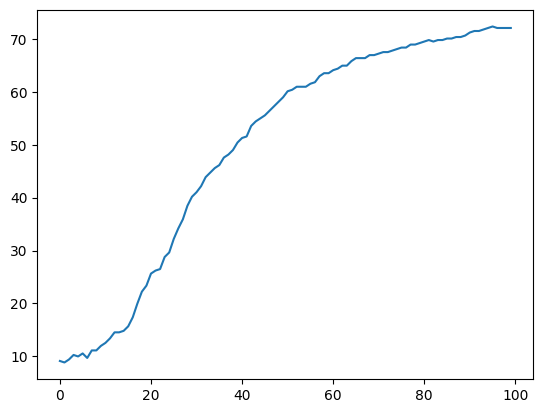

In [ ]:
if torch.cuda.is_available():
    my_device = torch.device("cuda:0")
else:
    my_device = torch.device("cpu")

print(f"Running on {my_device.type}")
    
model = modelResNetTL.to(my_device)

epochs = 100
lr = 1e-4
dataset = 'SoyBean'
prefix = 'ResNet18-Adam-TL-{}-e-{}-lr-{}'.format(dataset, epochs, lr)

# treina o modelo
net = train(train_tensors, test_tensors, model, len(train_data),
            epochs=epochs, device=my_device, save=True, 
            prefix=prefix, lr=lr, layers2tensorboard=True, batch_size=batch_size)

In [ ]:
def sample_and_predict ( net, seed=None ) :

    if seed is not None :
        np.random.seed(seed)

    dataset = torchvision.datasets.ImageFolder(root=dataset_path, transform=None)

    data = train_test_dataset(dataset, 0.30)[1]
    
    # my_transform = AlexNet_Weights.IMAGENET1K_V1.transforms()
    # my_transform = ResNet18_Weights.IMAGENET1K_V1.transforms()
    i = np.random.randint(len(data))
    
    sample = data[i][0]
    plt.figure(figsize=(2,2))
    plt.axis('off')
    plt.imshow( sample )

    print( f'Sample id: {i:3d}' )
    
    x = my_transform(sample)
    print(x.shape)

    x = x.unsqueeze_(0)
    print(x.shape)

    x = x.to(my_device)
    
    output = net ( x )
    predictions = output.squeeze(0).softmax(0)
        
    predicted_class = torch.argmax(predictions)
    predicted_class = predicted_class.data.cpu().item()
    
    confidence = predictions[predicted_class]
    confidence = confidence.data.cpu().item()
    
    dataset_classes = [
        "bacterial_blight", "brown_spot", "crestamento", "ferrugem", "mossaic_virus", "powdery_mildew",
        "septoria", "southern_blight", "sudden_death_syndrone", "yellow_mosaic"
    ]

    if predicted_class == data[i][1] : print('Hit')
    else: print('Miss')

    print(predicted_class)
    print( f'Predicted: {dataset_classes[predicted_class]} | Corrected: {dataset_classes[data[i][1]]} | Confidence: {confidence*100:.2f}%'  )
    
sample_and_predict(net)
